#  Markov Chain Monte Carlo in Practice

The two most popular python modules are PyMC and emcee. Quoting 
[Jake's blog:](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)

** emcee **

*The emcee package (also known as MCMC Hammer, which is in the running for best Python package name in history) is a Pure Python package written by Astronomer Dan Foreman-Mackey. It is a lightweight package which implements a fairly sophisticated Affine-invariant Hamiltonian MCMC. Because the package is pure Python (i.e. it contains no compiled extensions) it is extremely easy to install; with pip, simply type at the command-line "pip install emcee".*

*Emcee does not have much specific boilerplate code; it simply requires you to pass it a Python function which returns a value proportional to the log-posterior probability, and returns samples from that posterior.*

** PyMC **

*The PyMC package has many more features than emcee, including built-in support for efficient sampling of common prior distributions. PyMC by default uses the classic Metropolis-Hastings sampler, one of the earliest MCMC algorithms. For performance, it uses compiled fortran libraries, so it is less trivial to install using tools like pip. My machine has a working fortran compiler, so pip install pymc worked without a problem (but from working with students, colleagues, and tutorial attendees, I can tell you that few scientists today have a system setup such that this will work out-of-the-box). For folks who don't have a fortran compiler installed, PyMC binaries for many systems can be quite easily installed with conda.*


## MCMC example: sampling a Gaussian

In [21]:
%matplotlib inline

In [45]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
plt.rc('text', usetex=True)

In [46]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['ytick.labelsize'] = 24
mpl.rcParams['axes.labelsize'] = 26
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['lines.linewidth'] = 2.5

In [57]:
import emcee
np.random.seed(21)
Ndata = 100
mu = 1.0
sigma = 0.5 # assumed known 
data = stats.norm(mu, sigma).rvs(Ndata)

def Likelihood(x,sigma, data):
    # Gaussian likelihood 
    return np.prod(np.exp(-(data-x)**2/2/sigma**2))

def Prior(x):
    return 1.0/10   # flat uninformative prior: has no effect 

def myPosterior(x, sigma, data):
    # building posterior probability density function
    return Likelihood(x, sigma, data)*Prior(x) 

# note that emcee works with natural logarithm of posterior pdf
def myLogPosterior(x, sigma, data):
    return np.log(myPosterior(x, sigma, data))

# emcee combines multiple "walkers", each of which is its own MCMC chain. 
# the number of trace results will be nwalkers * nsteps
ndim = 1  # number of parameters in the model
nwalkers = 6  # number of MCMC walkers
Nburn = 100  # "burn-in" period to let chains stabilize; discarged further
nsteps = 500  # number of MCMC steps to take

# initialize 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

# the MCMC run 
sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[sigma, data])
sampler.run_mcmc(starting_guesses, nsteps, progress=True)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# discarge burn-in period and reshape:
emcee_trace  = sampler.chain[:, Nburn:, :].reshape(-1, ndim).T

print("done")

100%|██████████| 500/500 [00:00<00:00, 1131.77it/s]

done


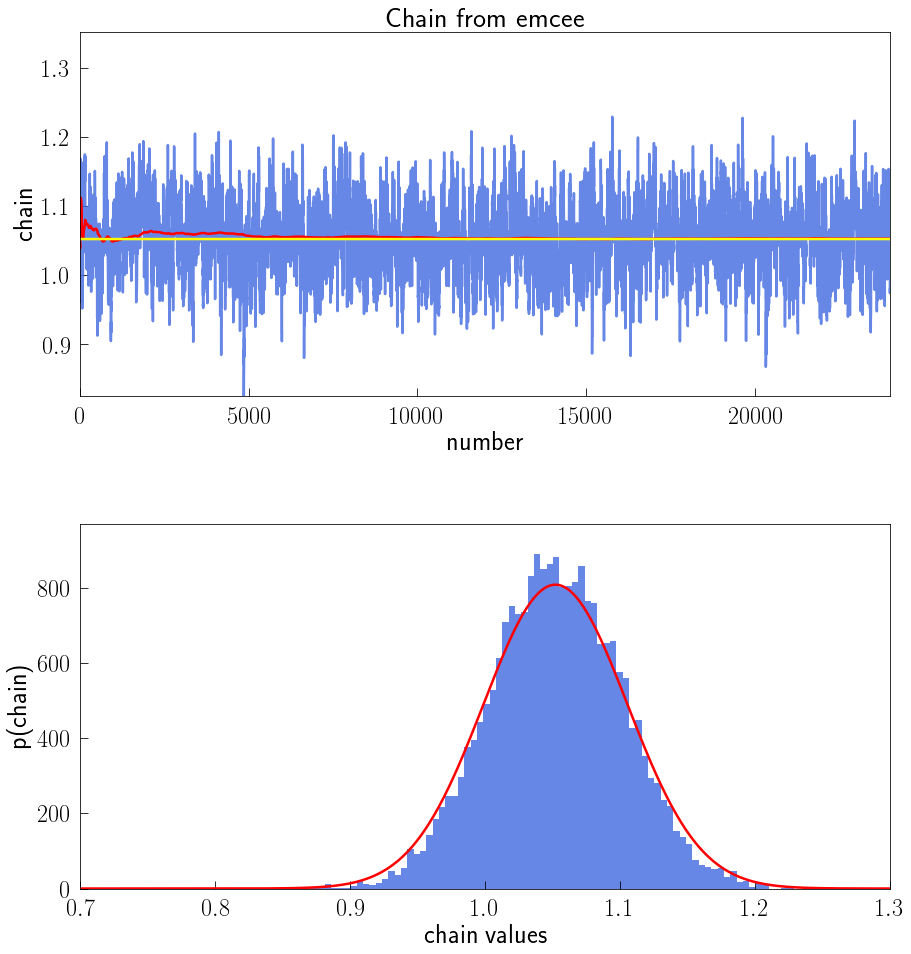

In [50]:
# plot 
fig,ax = plt.subplots(2,1,figsize=(15, 17))
fig.subplots_adjust(left=0.1, right=0.85, hspace=0.35, bottom=0.18)

chainE = emcee_trace[0]
M = np.size(chainE)

x = np.linspace(1,M,M)
ax[0].plot(x, chainE, color='royalblue', alpha=0.8)
ax[0].axis([0, M, np.min(chainE), 1.1*np.max(chainE)])
ax[0].set_xlabel('number')
ax[0].set_ylabel('chain')
# plot running mean: 
meanC = [np.mean(chainE[:int(N)]) for N in x]
ax[0].plot(x, meanC,c='red') 
ax[0].plot(x, 0*x+np.mean(data),c='yellow') 

# skip first Nburn samples
Nburn = 1000
Nchain = np.size(chainE[x>Nburn])
Nhist, bins, patches = ax[1].hist(chainE[x>Nburn], bins='auto', histtype='stepfilled', color='royalblue', alpha=0.8)
# plot expectations based on CLT
binwidth = bins[1]-bins[0]
muCLT = np.mean(data)
sigCLT = np.std(data)/np.sqrt(Ndata)
muGrid = np.linspace(0.7, 1.3, 500)
gauss = Nchain*binwidth*stats.norm(muCLT, sigCLT).pdf(muGrid) 
ax[1].plot(muGrid, gauss, c='red') 
ax[1].set_ylabel('p(chain)')
ax[1].set_xlabel('chain values')
ax[1].set_xlim(0.7, 1.3)
ax[1].set_ylim(0, 1.2*np.max(gauss))
ax[0].set_title('Chain from emcee', fontsize = 28)


plt.show() 